## Import Necessary Libraries
* Introducing Ultralytics YOLOv8, the latest version of the acclaimed real-time object detection and image segmentation model.
* Install YOLOv8 via the ultralytics pip package for the latest stable release

In [1]:
# Install the ultralytics package from PyPI
! pip install ultralytics
! pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 614.2/614.2 kB 13.3 MB/s eta 0:00:00


In [2]:
# Importing the required libraries
import os
import random
import pandas as pd
import wandb
from kaggle_secrets import UserSecretsClient

import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
from ultralytics import YOLO
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Wandb login:
user_secrets = UserSecretsClient()
secret_value = user_secrets.get_secret("wandb_api_key")
wandb.login(key=secret_value)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Explore the Dataset

In [4]:
# Define the paths to the images and labels directories
train_images = '/kaggle/input/aquarium-data-cots/aquarium_pretrain/train/images'
train_labels = '/kaggle/input/aquarium-data-cots/aquarium_pretrain/train/labels'

val_images = '/kaggle/input/aquarium-data-cots/aquarium_pretrain/valid/images'
val_labels = '/kaggle/input/aquarium-data-cots/aquarium_pretrain/valid/labels'

test_images = '/kaggle/input/aquarium-data-cots/aquarium_pretrain/test/images'
test_labels = '/kaggle/input/aquarium-data-cots/aquarium_pretrain/test/labels'

# Define the path to the yaml data file
yaml_path = '/kaggle/input/aquarium-data-cots/aquarium_pretrain/data.yaml'

In [5]:
# Define the labels
classes = ['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']
Idx2Label = {idx: label for idx, label in enumerate(classes)}
Label2Index = {label: idx for idx, label in Idx2Label.items()}
print('Index to Label Mapping:', Idx2Label)
print('Label to Index Mapping:', Label2Index)

Index to Label Mapping: {0: 'fish', 1: 'jellyfish', 2: 'penguin', 3: 'puffin', 4: 'shark', 5: 'starfish', 6: 'stingray'}
Label to Index Mapping: {'fish': 0, 'jellyfish': 1, 'penguin': 2, 'puffin': 3, 'shark': 4, 'starfish': 5, 'stingray': 6}


### Visualizing sample images with corresponding annotation bounding boxes

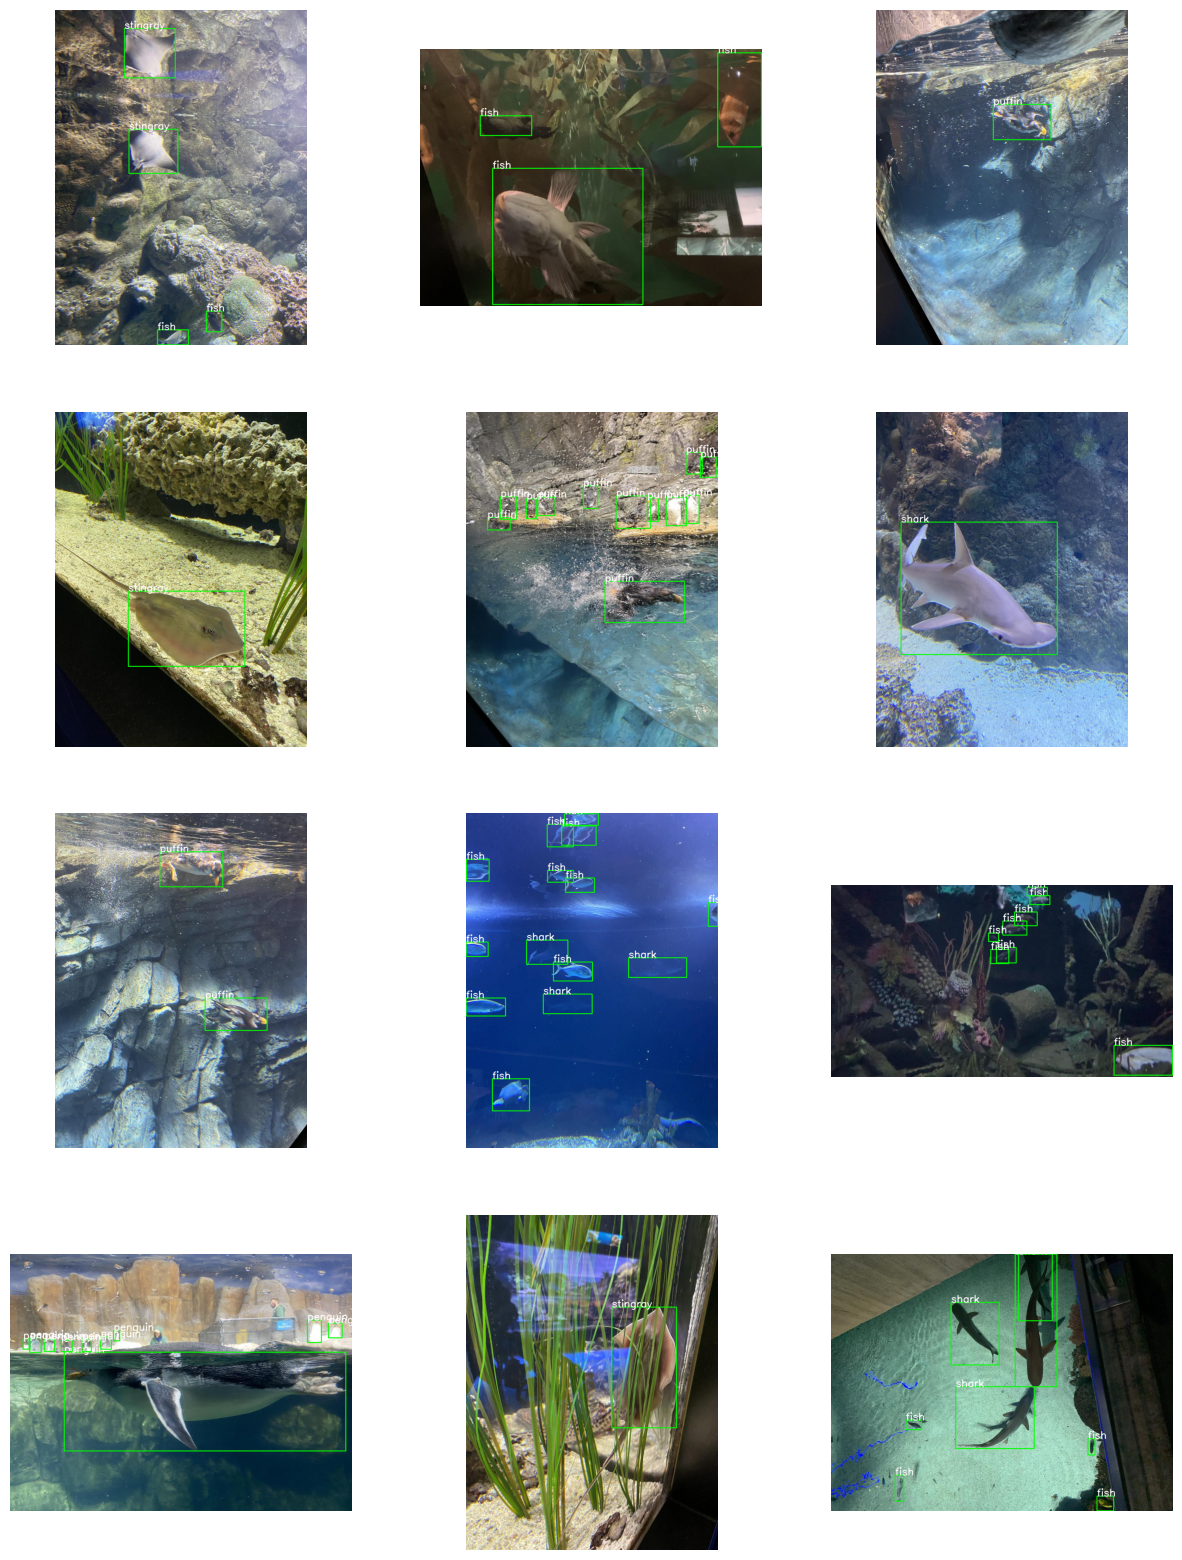

In [6]:
def visualize_image_with_annotation_bboxes(image_dir, label_dir):
    # Get list of all the image files in the directory
    image_files = sorted(os.listdir(image_dir))
    
    # Choose 10 random image files from the list
    sample_image_files = random.sample(image_files, 12)
    
    # Set up the plot
    fig, axs = plt.subplots(4, 3, figsize=(15, 20))
    
    # Loop over the random images and plot the bounding boxes
    for i, image_file in enumerate(sample_image_files):
        row = i // 3
        col = i % 3
        
        # Load the image
        image_path = os.path.join(image_dir, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Load the labels for this image
        label_path = os.path.join(label_dir, image_file[:-4] + '.txt')
        f = open(label_path, 'r')
        
        # Loop over the labels and plot the bounding boxes
        for label in f:
            class_id, x_center, y_center, width, height = map(float, label.split())
            h, w, _ = image.shape
            x_min = int((x_center - width/2) * w)
            y_min = int((y_center - height/2) * h)
            x_max = int((x_center + width/2) * w)
            y_max = int((y_center + height/2) * h)
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            cv2.putText(image, Idx2Label[int(class_id)], (x_min, y_min), cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)
    
        axs[row, col].imshow(image)
        axs[row, col].axis('off')

    plt.show()

# Visualize 6 sample images with bounding boxes
visualize_image_with_annotation_bboxes(train_images, train_labels)

In [7]:
# Read a image by path
image_path = os.path.join(train_images, os.listdir(train_images)[100])
image = cv2.imread(image_path)

# Get the size of the image
height, width, channels = image.shape
print('The image has dimensions {}x{} and {} channels'.format(height, width, channels))

The image has dimensions 1024x768 and 3 channels


In [8]:
%%writefile /kaggle/working/data.yaml
# Path
train: /kaggle/input/aquarium-data-cots/aquarium_pretrain/train/images
val: /kaggle/input/aquarium-data-cots/aquarium_pretrain/valid/images
test: /kaggle/input/aquarium-data-cots/aquarium_pretrain/test/images

# Classes
nc: 7
names: ['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']

Writing /kaggle/working/data.yaml


## Model Training
Train mode is used for training a YOLOv8 model on a custom dataset. In this mode, the model is trained using the specified dataset and hyperparameters. The training process involves optimizing the model's parameters so that it can accurately predict the classes and locations of objects in an image.

In [9]:
# Load a pretrained nano model
model = YOLO('yolov8n.pt')

# free up GPU memory
torch.cuda.empty_cache()

# Training the model
results = model.train(
    data='/kaggle/working/data.yaml',
    epochs=100,
    imgsz=(height, width, channels),
    seed=42,
    batch=16, 
    workers=4,
    name='yolov8n_custom')

100%|██████████| 6.23M/6.23M [00:00<00:00, 73.1MB/s]
Ultralytics YOLOv8.0.171 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/data.yaml, epochs=100, patience=50, batch=16, imgsz=(1024, 768, 3), save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=yolov8n_custom, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, cla

## Model Performance:
* Train Box Loss: measures the difference between the predicted bounding boxes and the actual bounding boxes of the objects in the training data.
* Train Class Loss: measures the difference between the predicted class probabilities and the actual class labels of the objects in the training data.
* Train DFL (Dynamic Feature Learning) Loss: measures the difference between the predicted feature maps and the actual feature maps of the objects in the training data.
* Metrics Precision (B): measures the proportion of true positive detections among all the predicted bounding boxes.
* Metrics Recall (B): metric measures the proportion of true positive detections among all the actual bounding boxes.
* Metrics mAP50 (B): measures the mean average precision of the model across different object categories, with a 50% intersection-over-union (IoU) threshold.
* Metrics mAP50-95 (B): measures the mean average precision of the model across different object categories, with IoU thresholds ranging from 50% to 95%.

In [10]:
%matplotlib inline
# read in the results.csv file as a pandas dataframe
df = pd.read_csv('/kaggle/working/runs/detect/yolov8n_custom/results.csv')
df.columns = df.columns.str.strip()

# create subplots using seaborn
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

# set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')

# add suptitle and subheader
plt.suptitle('Training Metrics and Loss', fontsize=24)

# adjust top margin to make space for suptitle
plt.subplots_adjust(top=0.8)

# adjust spacing between subplots
plt.tight_layout()

plt.show()

## Evaluation

In [11]:
# Loading the best performing model
model = YOLO('/kaggle/working/runs/detect/yolov8n_custom/weights/best.pt')

# Evaluating the model on test dataset
metrics = model.val(conf=0.25, split='test')

Ultralytics YOLOv8.0.171 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
Model summary (fused): 168 layers, 3007013 parameters, 0 gradients
val: Scanning /kaggle/input/aquarium-data-cots/aquarium_pretrain/test/labels... 63 images, 0 backgrounds, 0 corrupt: 100%|██████████| 63/63 [00:00<00:00, 90.35it/s]
val: WARNING ⚠️ Cache directory /kaggle/input/aquarium-data-cots/aquarium_pretrain/test is not writeable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]
                   all         63        584      0.816      0.683      0.796      0.533
                  fish         63        249      0.843      0.649      0.805      0.526
             jellyfish         63        154      0.888      0.772      0.866      0.608
               penguin         63         82      0.946      0.638      0.837        0.4
                puffin         63         35      0.725    

In [12]:
print(f"Mean Average Precision @.5:.95 : {metrics.box.map}")    
print(f"Mean Average Precision @ .50   : {metrics.box.map50}") 
print(f"Mean Average Precision @ .70   : {metrics.box.map75}")

Mean Average Precision @.5:.95 : 0.5325153818291493
Mean Average Precision @ .50   : 0.7957134201168232
Mean Average Precision @ .70   : 0.606471093124351


## Making Predictions on Test Images

In [13]:
# Function to perform detections with trained model
def predict_detection(image_path):
    # Read the image
    image = cv2.imread(image_path)
    
    # Pass the image through the detection model and get the result
    detect_result = model(image)
    
    # Plot the detections
    detect_image = detect_result[0].plot()
    
    # Convert the image to RGB format
    detect_image = cv2.cvtColor(detect_image, cv2.COLOR_BGR2RGB)
    
    return detect_image


0: 1024x768 23 penguins, 59.7ms
Speed: 2.6ms preprocess, 59.7ms inference, 1.9ms postprocess per image at shape (1, 3, 1024, 768)

0: 1024x768 2 fishs, 1 starfish, 6.2ms
Speed: 3.0ms preprocess, 6.2ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 768)

0: 1024x768 21 penguins, 5.8ms
Speed: 2.8ms preprocess, 5.8ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 768)

0: 768x1024 11 fishs, 1 shark, 1 stingray, 56.7ms
Speed: 3.0ms preprocess, 56.7ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)

0: 1024x768 11 jellyfishs, 6.6ms
Speed: 2.4ms preprocess, 6.6ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 768)

0: 1024x768 19 jellyfishs, 6.0ms
Speed: 2.8ms preprocess, 6.0ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 768)

0: 1024x768 14 fishs, 1 shark, 5.9ms
Speed: 2.9ms preprocess, 5.9ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 768)

0: 1024x768 1 fish, 1 starfish, 5.7ms
Speed: 2.3ms prepr

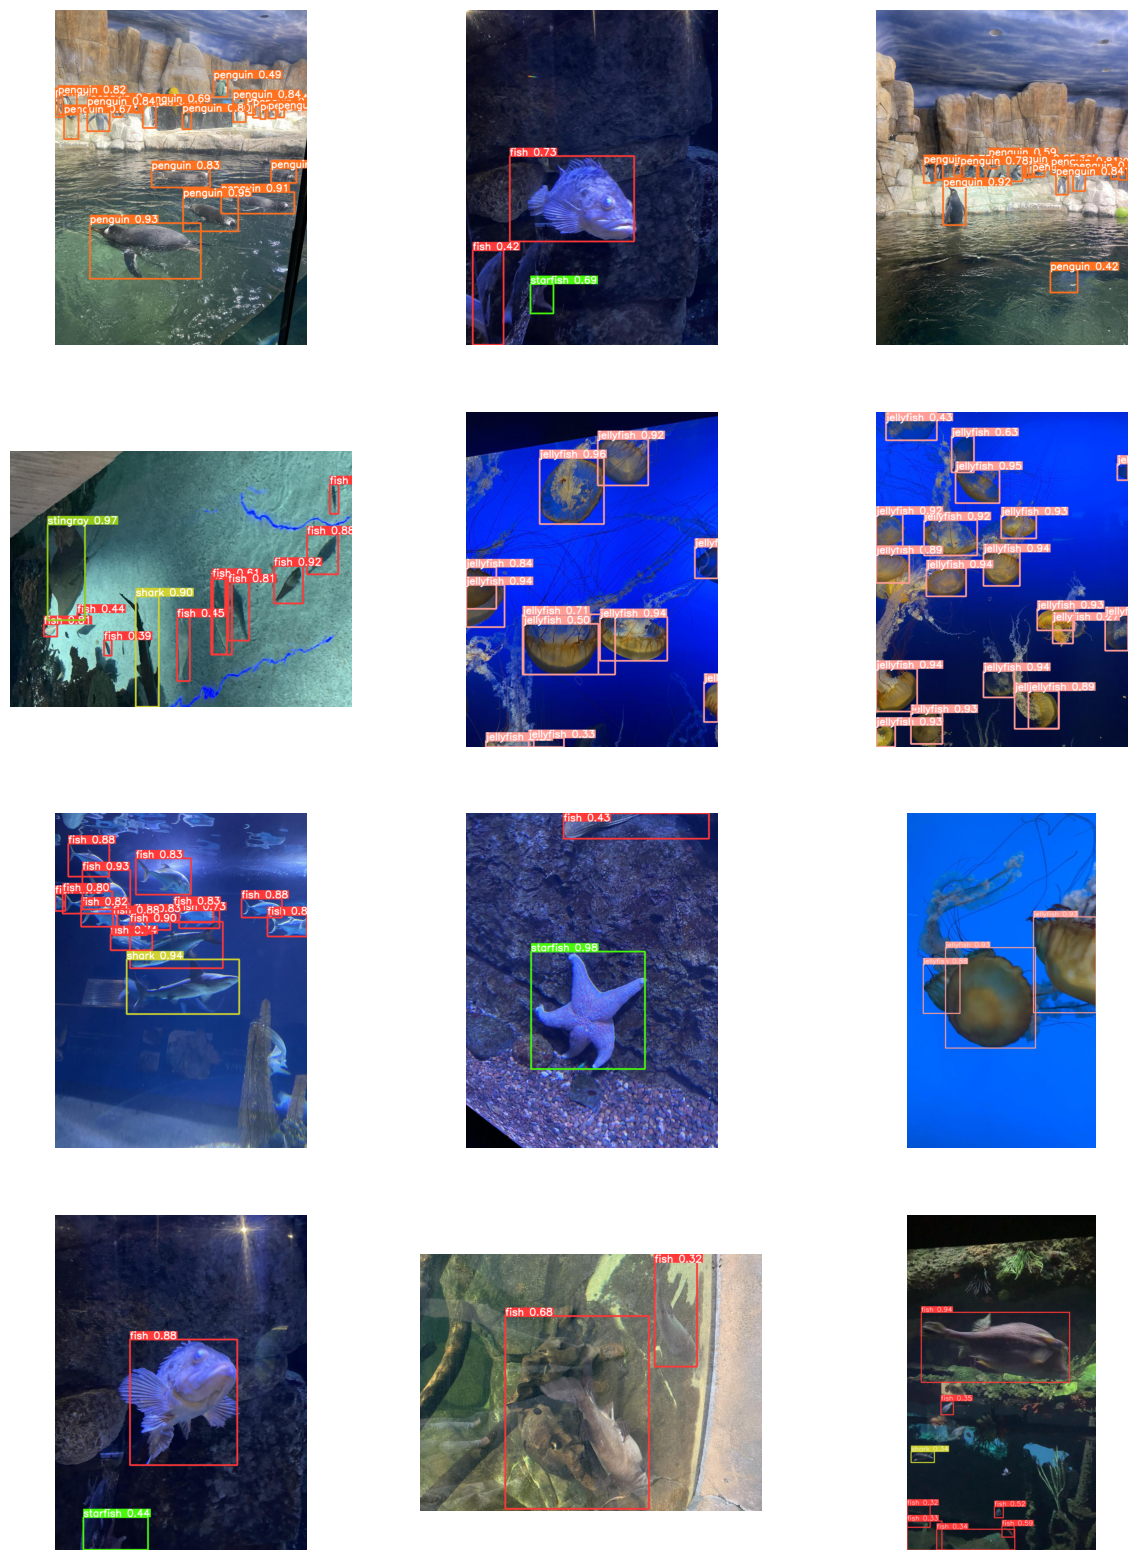

In [14]:
# Get list of all the image files in the test directory
image_files = sorted(os.listdir(test_images))
    
# Choose 12 random image files from the list
sample_image_files = random.sample(image_files, 12)
    
# Set up the plot
fig, axs = plt.subplots(4, 3, figsize=(15, 20))
    
# Loop over the random images and plot the detections of the trained model
for i, image_file in enumerate(sample_image_files):
    row = i // 3
    col = i % 3
        
    # Load the current image and run object detection
    image_path = os.path.join(test_images, image_file)
    detect_image = predict_detection(image_path)
    
    axs[row, col].imshow(detect_image)
    axs[row, col].axis('off')

plt.show()

## References:
* https://docs.ultralytics.com/
* https://www.kaggle.com/code/vencerlanz09/wind-turbines-object-detection-using-yolov8/notebook